In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_path = '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25'

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 256

# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    width_shift_range=0.2,  # Add width shift
    height_shift_range=0.2, # Add height shift
    horizontal_flip=True,
    validation_split=0.1
)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0/255
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)
# Load and preprocess test images
test_generator = test_datagen.flow_from_directory(
    '/content/drive/My Drive/Facial_Emotion_Recognition_Project/FER_25/Test',  # Path to the test dataset
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5846 images belonging to 7 classes.
Found 647 images belonging to 7 classes.
Found 717 images belonging to 7 classes.


In [4]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam

# Create Precision and Recall metrics outside the function
precision_metric = Precision()
recall_metric = Recall()

# Custom F1-score metric
def f1_score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)  # Use pre-created metric
    recall = recall_metric(y_true, y_pred)      # Use pre-created metric
    f1 = 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    return f1

# Apply mixed precision for faster training and less GPU load
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

# Load pre-trained EfficientNetB3 model without the top classification layer
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model to retain pre-trained weights
base_model.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
# Apply the output layer to the previous layer's output
output = Dense(7, activation='softmax')(x)  # 7 classes: anger, disgust, fear, happiness, neutral, sadness and surprise

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)             

 Total params: 11,574,070 (44.15 MB)

 Trainable params: 790,535 (3.02 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [6]:
import tensorflow as tf

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 260s 7s/step - accuracy: 0.1475 - f1_score: 0.0130 - loss: 2.0503 - precision: 0.1956 - recall: 0.0047 - val_accuracy: 0.1484 - val_f1_score: 0.0033 - val_loss: 1.9503 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
 1/22 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.0898 - f1_score: 0.0031 - loss: 1.9872 - precision: 0.0000e+00 - recall: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 386ms/step - accuracy: 0.0898 - f1_score: 0.0031 - loss: 1.9872 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1504 - val_f1_score: 0.0029 - val_loss: 1.9466 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.1525 - f1_score: 0.0024 - loss: 1.9497 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1836 - val_f1_score: 0.0016 - val_loss: 1.9416 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 385ms/step - accuracy: 0.1719 - f1_score: 0.0015 - loss: 1.9417 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1875 - val_f1_score: 0.0015 - val_loss: 1.9420 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.1527 - f1_score: 0.0013 - loss: 1.9443 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2070 - val_f1_score: 0.0010 - val_loss: 1.9

In [7]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 52s 24s/step - accuracy: 0.2034 - f1_score: 1.9325e-04 - loss: 1.9180 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Accuracy: 19.78%


In [ ]:
# Unfreeze the base model for fine-tuning
base_model.trainable = True

# Use a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), f1_score]
)

# Fine-tune the model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # Add more epochs for fine-tuning
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

In [ ]:
# Evaluate the model and unpack the returned values appropriately
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(validation_generator)

# Print the test accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Define class names
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Initialize dictionaries before the loop
fpr = dict()
tpr = dict()
roc_auc = dict()

y_pred_prob = model.predict(validation_generator)
y_val = validation_generator.classes
n_classes = len(emotion_categories)
y_val_binary = label_binarize(y_val, classes=range(n_classes))

# Calculate and apply optimal thresholds
optimal_thresholds = []
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_val_binary[:, i], y_pred_prob[:, i])
    optimal_idx = np.argmax(tpr - fpr)  # Find index of optimal threshold
    optimal_thresholds.append(thresholds[optimal_idx])

y_pred_adjusted = (y_pred_prob > optimal_thresholds).astype(int)  # Apply thresholds

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.figure(figsize=(10, 8))
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 12s/step


NameError: name 'plt' is not defined

3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step


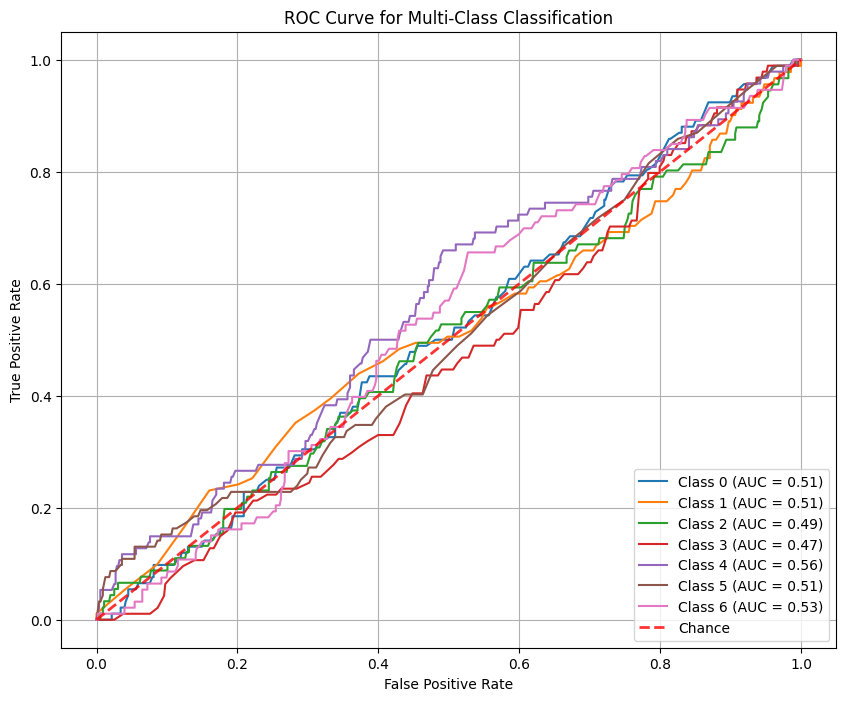

In [8]:
# Errors fixed, clean code for ROC

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Define class names
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Initialize dictionaries
fpr = dict()
tpr = dict()
roc_auc = dict()

# Get model predictions and true labels
y_pred_prob = model.predict(validation_generator)
y_val = validation_generator.classes
n_classes = len(emotion_categories)
y_val_binary = label_binarize(y_val, classes=range(n_classes))

# Calculate and store ROC curves + optimal thresholds
optimal_thresholds = []
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr[i], tpr[i], thresholds = roc_curve(y_val_binary[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # Find optimal threshold
    optimal_idx = np.argmax(tpr[i] - fpr[i])
    optimal_thresholds.append(thresholds[optimal_idx])

    # Plot ROC curve for class i
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Adjust predictions using optimal thresholds
y_pred_adjusted = np.zeros_like(y_pred_prob)
for i in range(n_classes):
    y_pred_adjusted[:, i] = (y_pred_prob[:, i] > optimal_thresholds[i]).astype(int)

# Plot reference line
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Chance')

# Formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.grid()
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


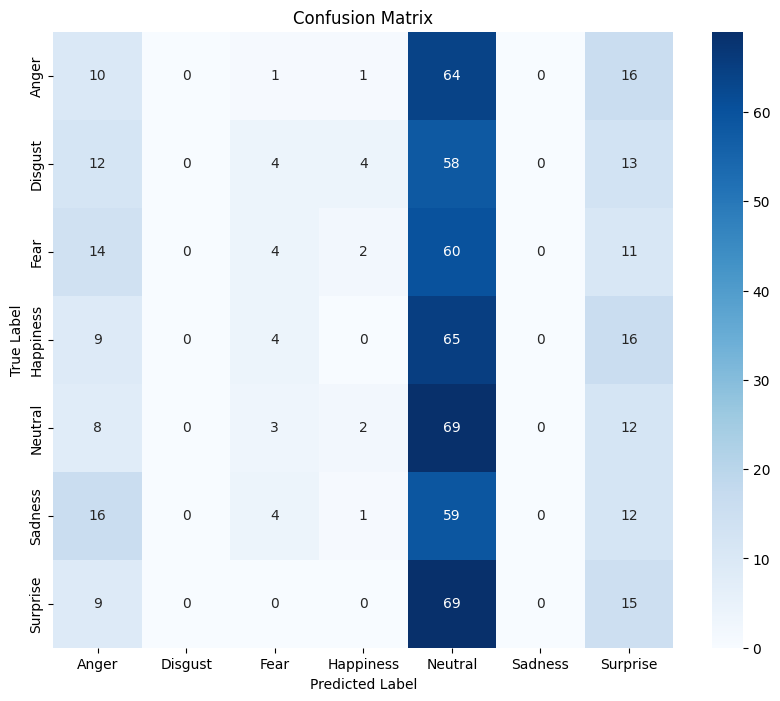

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']
y_pred_prob = model.predict(validation_generator)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = y_val

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Function to plot confusion matrix
def plot_confusion_matrix_custom(cm, class_names):
    """Custom heatmap for the confusion matrix."""
    plt.figure(figsize=(10, 8))  # Adjust size if needed
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
# Plot the confusion matrix
plot_confusion_matrix_custom(cm, emotion_categories)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


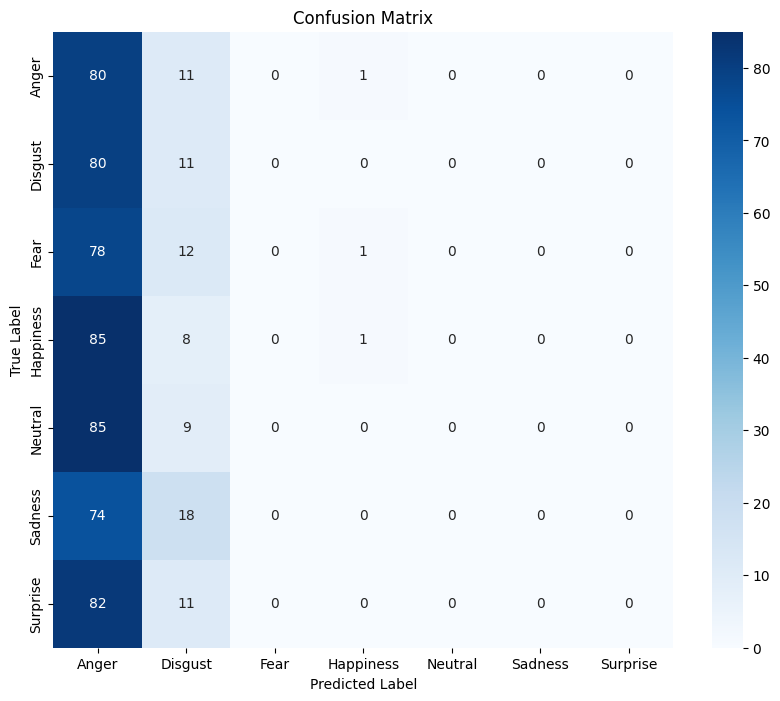

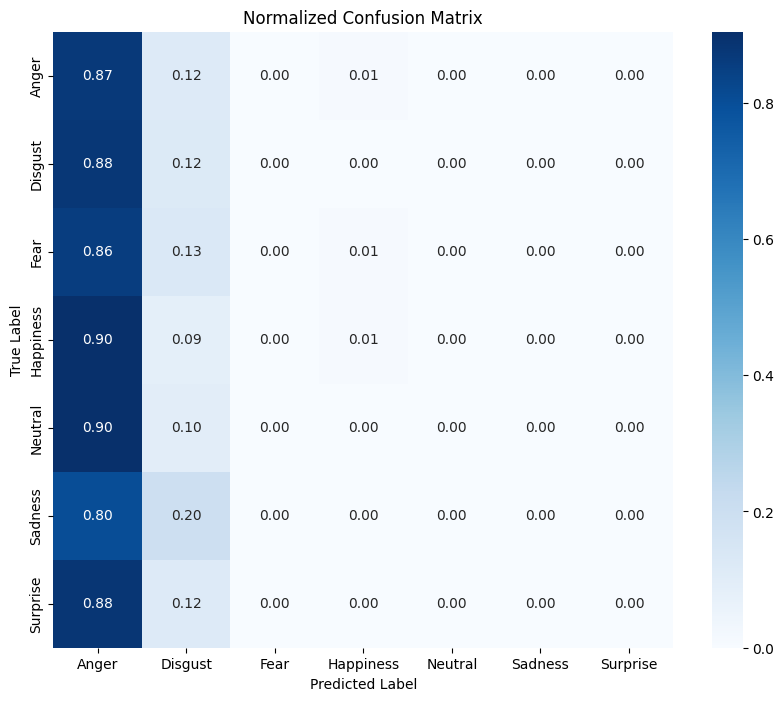

In [10]:
# clean code for cm

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define class names
emotion_categories = ['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness', 'Surprise']

# Get model predictions and apply optimal thresholds
y_pred_prob = model.predict(validation_generator)

# Apply optimal thresholds per class
y_pred_adjusted = np.zeros_like(y_pred_prob)
for i in range(len(emotion_categories)):
    y_pred_adjusted[:, i] = (y_pred_prob[:, i] > optimal_thresholds[i]).astype(int)

# Convert multi-label predictions to single-class labels
y_pred = np.argmax(y_pred_adjusted, axis=1)
y_true = y_val

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize the confusion matrix (optional)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Function to plot confusion matrix
def plot_confusion_matrix_custom(cm, class_names, normalize=False):
    """Custom heatmap for the confusion matrix."""
    plt.figure(figsize=(10, 8))  # Adjust size if needed

    if normalize:
        sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        title = 'Normalized Confusion Matrix'
    else:
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        title = 'Confusion Matrix'

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Plot both standard and normalized confusion matrices
plot_confusion_matrix_custom(cm, emotion_categories, normalize=False)
plot_confusion_matrix_custom(cm_normalized, emotion_categories, normalize=True)

NameError: name 'y_test' is not defined

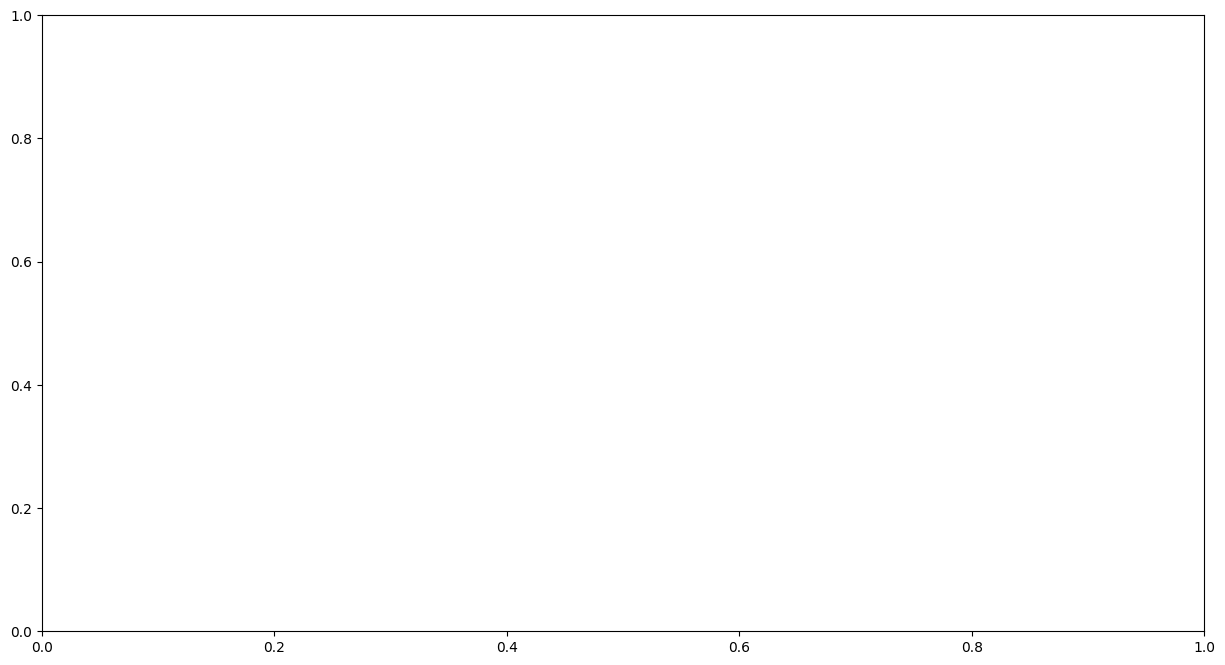

In [11]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_pred[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()